## Napisać symulację procesu kolejkowego M/M/1 (najlepiej od razu przypadek ogólny dla M/M/k/c)dla parametrów λA=1/(20min)  i λs=1/(15min).

### Proszę zbadać zależność następujących wielkości:

* 13.E(x) , gdzie x– całkowita liczba zdarzeń w systemie
* 14.E(R), gdzie R – całkowity czas spędzony w systemie
* 15.E(xw), gdzie xw– liczba zadań w kolejce 

##### od parametrów procesu λA i λs oraz ich zbieżność w czasie.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Events():
    empty = True
    
    def __init__(self):
        self.t_arr_cumul = [0]  # task arrival time
        self.t_serv = [0]
        self.t_in = [0]  # task input time
        self.t_out = [0] # task out time 
        self.t_marked = [0]
        self.tasks_in_sys = [0]
        self.time_in_sys = None
        self.task_queue = None
        
        
    def add_event(self, t_arrive, t_service):
#         if self.empty:
#             self.empty = not self.empty
        self.t_arr_cumul.append(self.t_arr_cumul[-1]+t_arrive)
        self.t_serv.append(t_service)           
        self.t_in.append(max(t_arrive+self.t_arr_cumul[-1], self.t_out[-1]))
        self.t_out.append(t_service + self.t_in[-1])
        
    
    def prepare_total_marked(self):
        t_marked = np.ones((len(self.t_arr_cumul) + len(self.t_out),2))
        show_up_stamp = 0
        out_stamp = 1

        for idx, k in enumerate(self.t_arr_cumul):
            t_marked[idx, 0]= k
            t_marked[idx, 1]= show_up_stamp
        offset  = len(self.t_arr_cumul)

        for idx, k in enumerate(self.t_out):
            t_marked[offset+ idx, 0]= k
            t_marked[offset+ idx, 1]= out_stamp
        ind = np.argsort( t_marked[:,0] );
        self.t_marked = t_marked[ind]
        
    
    def calc_tasks_in_sys(self):
        tasks_in_system = np.zeros(len(self.t_marked))
        last_gen_idx = 0
        for idx, ev in enumerate(self.t_marked):
            if ev[1] == 0:
                tasks_in_system[idx] = tasks_in_system[idx-1] + 1
                last_gen_idx = idx
            else:
                tasks_in_system[idx] = tasks_in_system[idx-1] - 1
        self.tasks_in_sys = tasks_in_system
        
        
    def plot_tasks_in_sys(self,a=0,b=50):
        # plt.plot(total_marked[:last_gen_idx,0], tasks_in_system[:last_gen_idx])
        plt.plot(self.t_marked[:,0], self.tasks_in_sys)
        plt.title("Total tasks in system")
        plt.xlabel("time [minutes]")
        plt.ylabel("tasks count")
        plt.show()
        plt.scatter(self.t_marked[a:b,0], self.tasks_in_sys[a:b])
        plt.title("Tasks in system partial")
        plt.xlabel("time [minutes]")
        plt.ylabel("tasks count")
        plt.show()
        
        
    def calc_time_in_sys(self):
        time_in_sys = np.ones(len(self.t_arr_cumul))
        for idx, arr in enumerate(self.t_arr_cumul[1:]):
            time_in_sys[idx] = self.t_out[idx+1] - arr
        self.time_in_sys = time_in_sys
        
        
    def prepare_queue(self):
        t_queue = np.ones((len(self.t_arr_cumul) + len(self.t_in),2))
        show_up_stamp = 0
        in_stamp = 1

        for idx, k in enumerate(self.t_arr_cumul):
            t_queue[idx, 0]= k
            t_queue[idx, 1]= show_up_stamp
        offset  = len(self.t_arr_cumul)

        for idx, k in enumerate(self.t_in):
            t_queue[offset+ idx, 0]= k
            t_queue[offset+ idx, 1]= in_stamp
        ind = np.argsort( t_queue[:,0] );
        self.t_queue = t_queue[ind]
        
        
    def calc_queue(self, show_up_stamp=0, in_stamp=1):
        tasks_in_queue = np.zeros(len(self.t_queue))
        last_gen_idx = 0
        for idx, ev in enumerate(self.t_queue):
            if ev[1] == show_up_stamp:
                tasks_in_queue[idx] = tasks_in_queue[idx-1] + 1
                last_gen_idx = idx
            else:
                tasks_in_queue[idx] = tasks_in_queue[idx-1] - 1
        self.task_queue = tasks_in_queue

In [3]:
def estimate_x(t_marked_0_col, tasks_in_sys):
    """ function to estimate overall events in system"""
    assert len(t_marked_0_col) == len(tasks_in_sys)
    
    estimated = list(tasks_in_sys)
    tasks = list(tasks_in_sys)
    time_diffs = list(tasks_in_sys)
    
    for idx, task in enumerate(tasks_in_sys):
        if idx == len(tasks_in_sys)-1:
            break
        tasks[idx] = task
        time_diffs[idx] = t_marked_0_col[idx+1] - t_marked_0_col[idx]
    tasks = tasks[:-1]
    time_diffs = time_diffs[:-1]
    mults = [a*b for a,b in zip(tasks, time_diffs)]
    
    for idx, m in enumerate(mults):
        if idx == 0:
            continue
        else:
            estimated[idx] = sum(mults[:idx])/t_marked_0_col[idx]
        
    return estimated[1:-1]

In [4]:
def estimate_R(R):
    """
    function to estimate overall time in system per task
    
    :param R: time per task
    """
#     assert len(t_arr_cumul) == len(R), "Must have equal length"
    estimated = list(R)
    vals = list(R)
    for idx, t in enumerate(R):
        vals[idx] = t
        if len(vals[:idx]) == 0:
            continue
        else:
            estimated[idx-1] = sum(vals[:idx])/(len(vals[:idx])+0.0001)
    return estimated[:-1]

In [5]:
def estimate_xw(t_queue_0_col, x_w):
    """ function to estimate tasks in queue"""
    assert len(t_queue_0_col) == len(x_w)
    
    estimated = list(x_w)
    queued = list(x_w)
    time_diffs = list(x_w)
    
    for idx, queue in enumerate(x_w):
        if idx == len(x_w)-1:
            break
        queued[idx] = queue
        time_diffs[idx] = t_queue_0_col[idx+1] - t_queue_0_col[idx]
    queued = queued[:-1]
    time_diffs = time_diffs[:-1]
    mults = [a*b for a,b in zip(queued, time_diffs)]
    
    for idx, m in enumerate(mults):
        if idx == 0:
            continue
        else:
            estimated[idx] = sum(mults[:idx])/t_queue_0_col[idx]
        
    return estimated[1:-1]
    pass

In [6]:
random_seed = 123
rng = np.random.RandomState(seed=random_seed)

In [7]:
def generate_exponential(lmbda, title, size=1000, v=True, bins_scaler=200 ):
    time_exponential = rng.exponential(1./lmbda, size=size)
    if v:
        plt.hist(time_exponential,bins=int(size/bins_scaler))
        plt.title(title + " - sampled data")
        plt.show()
        # E(X) = 1/lmbda
        E_X = time_exponential.mean()
        print("estimated E_X = {}".format(E_X))
        print("thoeretical E_X = {}".format(1/lmbda))
    return time_exponential

In [8]:
# Wykladniczy rozklad czasu pomiedzy kolejny zgloszeniami do systemu
# lmbda * exp(-lmbda)
lmbda_a = 1./20. #min^-1
# Wykladniczy rozklad czasu obslugi pojedynczego zgloszenia
# lmbda * exp(-lmbda)
lmbda_s = 1./15. #min^-1
dataset_size = 10000

t_arrival = generate_exponential(lmbda_a, "arrival times", size=dataset_size, v=False)
t_service = generate_exponential(lmbda_s, "service times", size=dataset_size, v=False)

events = Events()
for idx, arrive in enumerate(t_arrival):
    events.add_event(arrive, t_service[idx])

events.prepare_total_marked()
events.calc_tasks_in_sys()

events.calc_time_in_sys()
# R - time in system
R = events.time_in_sys

events.prepare_queue()
events.calc_queue()
x_w = events.task_queue


In [9]:
estimatedx = estimate_x(events.t_marked[:,0], events.tasks_in_sys)

/home/karol/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


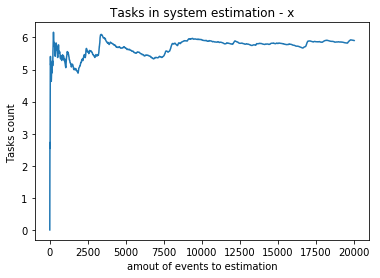

In [10]:
plt.plot(range(len(estimatedx)), estimatedx)
plt.title("Tasks in system estimation - x")
plt.xlabel("amout of events to estimation")
plt.ylabel("Tasks count ")
plt.show()

In [11]:
estimated = estimate_R(R)

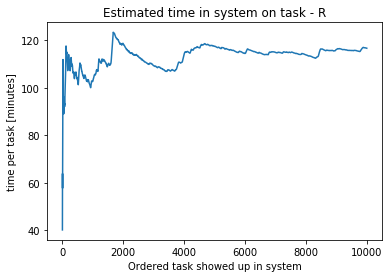

In [12]:
plt.plot(range(len(estimated)),estimated)
plt.title("Estimated time in system on task - R")
plt.xlabel("Ordered task showed up in system")
plt.ylabel("time per task [minutes]")
plt.show()

In [13]:
estimatedxw = estimate_xw(events.t_queue[:,0], x_w)

/home/karol/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


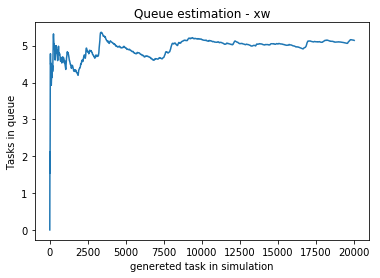

In [14]:
plt.plot(range(len(estimatedxw)), estimatedxw)
plt.title("Queue estimation - xw")
plt.xlabel("genereted task in simulation")
plt.ylabel("Tasks in queue")
plt.show()

